In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
import gseapy as gp
import anndata
from scipy import stats
import os
from sklearn.metrics import RocCurveDisplay, roc_curve
from scipy.spatial.distance import cdist
from collections import Counter
from adjustText import adjust_text  # Helps avoid overlapping labels
import matplotlib.lines as mlines
from eval_utils import *
from centroid_accuracy import calculate_centroid_accuracies

In [3]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
savedir = f'{outdir}/pairwise_scores'
datasets = ['Norman2019']
dataset_names = ['norman2019']
dataset_labels = ['Norman']
dataset_dict = {k: v for k, v in zip(dataset_names, datasets)}
dataset_label_dict = {k: v for k, v in zip(dataset_names, dataset_labels)}

seeds = [1]
methods = ['gears', 'scgpt', 'scgenept', 'nonctl-mean']

In [4]:
for dataset, dataset_name in tqdm(zip(datasets, dataset_names)):
    file = f'../data/{dataset_name}/{dataset_name}_{seeds[0]}.h5ad'
    adata = anndata.read_h5ad(file)

    # Calculate perturbation means
    unique_conds = list(set(adata.obs['condition'].unique()) - set(['ctrl']))
    double_perts = set([p for p in unique_conds if len(p.split('+')) < 2 or (p.split('+')[0] != 'ctrl' and p.split('+')[1] != 'ctrl')])
    unique_conds = list(set(unique_conds) - set(double_perts))
    post_gt_all_df = pd.DataFrame(columns=adata.var['gene_name'].values)
    for condition in tqdm(unique_conds):
        adata_condition = adata[adata.obs['condition'] == condition]
        X_post = np.array(adata_condition.X.mean(axis=0))[0]
        post_gt_all_df.loc[len(post_gt_all_df)] = X_post
    post_gt_all_df.index = unique_conds
    post_gt_all_df.index = [c[0] if len(c) == 1 or c[1] == 'ctrl' else c[1] for c in post_gt_all_df.index.str.split('+')]
    m = ~post_gt_all_df.isna().any()
    post_gt_all_df = post_gt_all_df.loc[:, m]

    post_pred_dfs = []
    for seed in seeds:
        for method in tqdm(methods):
            p = f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv'
            if not os.path.exists(p):
                print('Predictions not ready for method: ', method, 'dataset: ', dataset, 'seed: ', seed)
                continue
            post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
            post_pred_df['seed'] = seed
            post_pred_df['method'] = method
            post_pred_dfs.append(post_pred_df)

    # Merge predictions into a single dataframe
    post_pred_df = pd.concat(post_pred_dfs, axis=0)
    post_pred_df = post_pred_df.reset_index()
    post_pred_df['condition_split'] = post_pred_df['condition'].str.split('+')
    post_pred_df['condition'] = [c[0] if len(c) == 1 or c[1] == 'ctrl' else c[1] for c in post_pred_df['condition'].str.split('+')]
    post_pred_df = post_pred_df.set_index(['condition', 'method', 'seed'])
    post_pred_df = post_pred_df.loc[post_pred_df.index.get_level_values(0) != 'ctrl']

    # Remove a few duplicate genes
    duplicate_genes = [g for g, v in Counter(adata.var['gene_name']).items() if v > 1]
    genes = [g for g in post_gt_all_df.columns if g not in duplicate_genes]
    agg_post_pred_df = post_pred_df.reset_index().groupby(['condition', 'method'])[genes].mean()

    # Calculate pairwise scores
    scores_df = calculate_centroid_accuracies(agg_post_pred_df[genes], post_gt_all_df[genes])
    scores_df.to_csv(f'{savedir}/{dataset}.csv')
    print(dataset, len(scores_df))

0it [00:00, ?it/s]
100%|██████████████████████████████████| 152/152 [00:01<00:00, 124.05it/s]

100%|███████████████████████████████████████| 4/4 [00:00<00:00,  5.82it/s]
1it [00:04,  4.95s/it]

Norman2019 62


In [5]:
scores_df_all = None
for dataset, label in tqdm(zip(datasets, dataset_labels)):
    scores_df = pd.read_csv(f'{savedir}/{dataset}.csv')
    scores_df['dataset'] = label
    print(dataset, len(scores_df))
    if scores_df_all is None:
        scores_df_all = scores_df
    else:
        scores_df_all = pd.concat((scores_df_all, scores_df), axis=0)

1it [00:00, 398.89it/s]

Norman2019 62


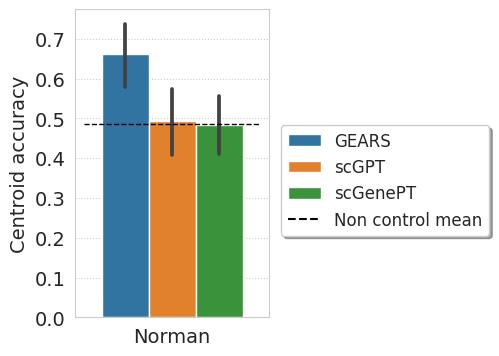

In [6]:
sns.set_style('whitegrid')
fontsize = 14

df = scores_df_all.melt(id_vars=['condition', 'dataset'], var_name='method', value_name='value')
nonctl_mean_acc =  df[df['method'] == 'nonctl-mean'].groupby('dataset')['value'].mean()
df_ = df[~df['method'].isin(['nonctl-mean'])]

fig = plt.figure(figsize=(2.5, 4))
ax = sns.barplot(df_, x='dataset', y='value', hue='method', hue_order=['gears', 'scgpt', 'scgenept'])
plt.grid(linestyle='dotted', axis='y')
plt.xlabel('')
plt.ylabel('Centroid accuracy', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

# Draw horizontal baseline lines
baseline_values = nonctl_mean_acc.values # [0.45, 0.50, 0.48, 0.49, 0.47, 0.50, 0.52]
x_positions = np.arange(len(baseline_values))
for x, baseline in zip(x_positions, baseline_values):
    ax.hlines(y=baseline, xmin=x-0.5, xmax=x+0.5, color='black', linestyles='dashed', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
baseline_handle = mlines.Line2D([], [], color='black', linestyle='dashed', linewidth=1.5, label='Random baseline')
labels=['GEARS', 'scGPT', 'scGenePT', 'Non control mean']
legend = ax.legend(handles+[baseline_handle], labels+['Non control mean'],
                   loc='upper center', bbox_to_anchor=(1.6, 0.65), 
                   fancybox=True, shadow=True, ncol=1, fontsize=fontsize-2)

for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label);
plt.show()
# plt.savefig(f'{figdir}/centroid_accuracy_per_dataset.pdf', bbox_inches='tight');

In [7]:
scores_df_all.gears.mean()

np.float64(0.6619813488309232)